In [1]:
%precision %.2f
%matplotlib inline
import pandas as pd
import numpy as np
from datetime import date

import src.compute.timeline as timeline
import src.compute.developer as developer
from src.compute.utils import Interval, statuses_of_interest
from src.db.utils import SnowflakeWrapper
from src.config import data_root

pd.options.display.float_format = '{:,.2f}'.format
np.set_printoptions(precision=2)
conn = SnowflakeWrapper.create_snowflake_connection()
sw = SnowflakeWrapper(conn)
figure_size = (18, 12)


In [2]:
active_interval: Interval = Interval(
    # fromDate=date(2019, 7, 1), # year, month, day
    # toDate=date(2019, 10, 1),
    fromDate=date(2019, 10, 1), # year, month, day
    toDate=date(2020, 1, 1)
)
print(active_interval)

('2019-10-01', '2020-01-01')


In [3]:
res = timeline.get_avg_timeline(sw, active_interval)
# display(res)

SELECT     STATUS                          "Status",     COUNT(DISTINCT KEY)             "UniqueIssues",     COUNT(*)                        "Issues",     "Issues" - "UniqueIssues"       "Reassignments",     AVG(TIMEDELTA) / (60 * 60 * 24) "AvgDays",     MAX(TIMEDELTA) / (60 * 60 * 24) "MaxDays",     MIN(TIMEDELTA) / (60 * 60 * 24) "MinDays" FROM TIMELINES t WHERE     t.DATEFROM >= '2019-10-01'     AND t.DATETO < '2020-01-01' GROUP BY 1 ORDER BY 1, 4 DESC; 


In [4]:
avg_dev = developer.get_avg_developer(sw, active_interval)
# display(avg_dev)

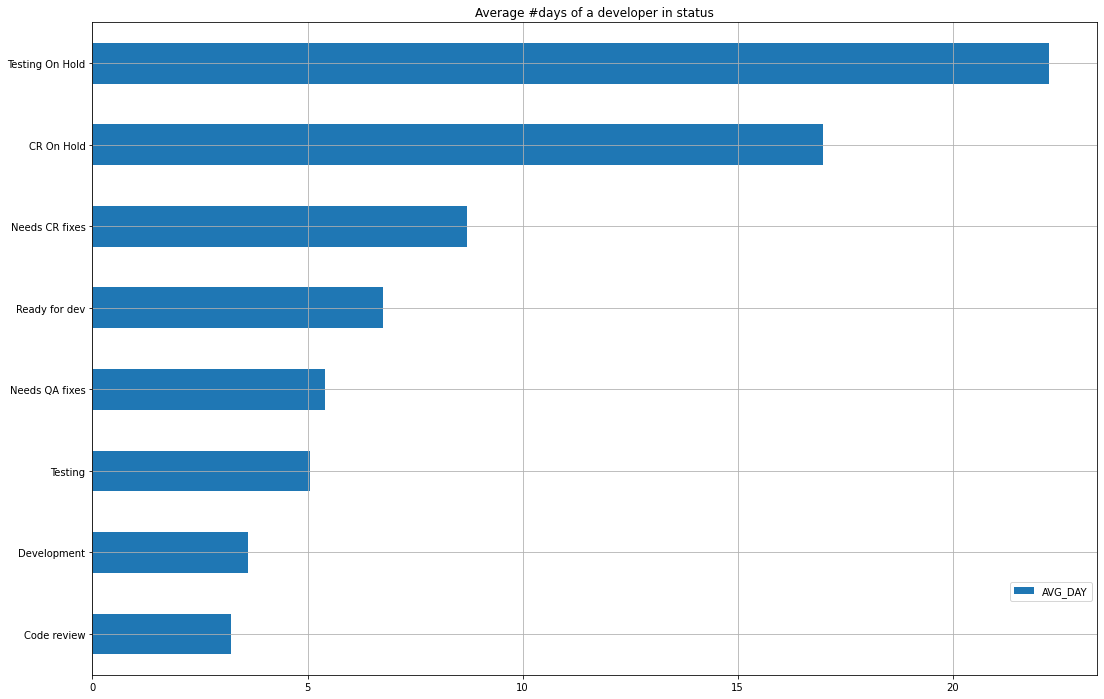

In [5]:
plot = avg_dev\
    .loc[avg_dev["STATUS"].isin(statuses_of_interest)]\
    .sort_values("AVG_DAY")\
    .plot(
        kind='barh',
        use_index=True,
        y='AVG_DAY',
        figsize=figure_size,
        grid=True,
        title="Average #days of a developer in status"
    )\
    .legend(bbox_to_anchor=(1, 0.15))
fig = plot.get_figure()
fig.savefig(f"{data_root}/figs/overall_avg_dev.png")

Spec in progress = 0.009 days


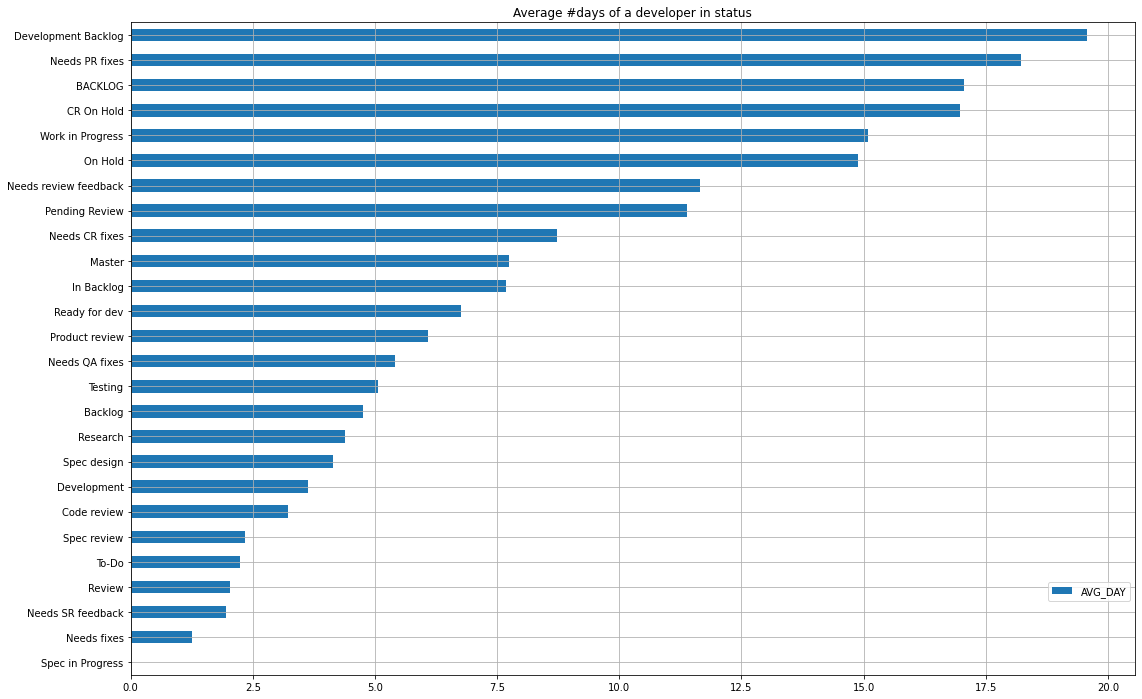

In [6]:
print("Spec in progress = 0.009 days")
avg_dev.loc[(avg_dev["AVG_DAY"] > 0) & (avg_dev["AVG_DAY"] < 20)]\
    .sort_values("AVG_DAY")\
    .plot(
        kind='barh',
        use_index=True,
        y='AVG_DAY',
        figsize=figure_size,
        grid=True,
        yticks=range(0, 20, 1),
        title="Average #days of a developer in status"
    )\
    .legend(bbox_to_anchor=(1, 0.15))

In [7]:
# avg_dev_merged = developer.get_avg_developer(sw, active_interval,merge=True)
# print("Not a good idea to merge the statuses because some statuses are obsolete, and cause noise in the data:")
# display(avg_dev_merged)

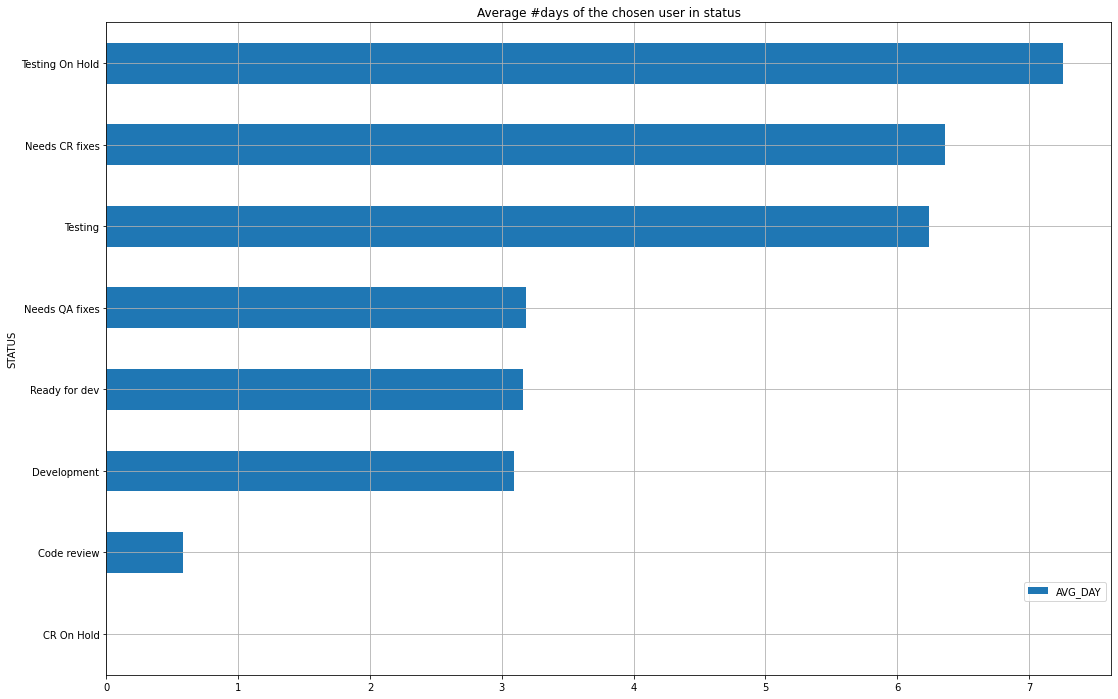

In [8]:
userId = "marko.prelevikj"
dev = developer.get_developer(sw, interval=active_interval, userId=userId)
plot = dev\
    .loc[dev["STATUS"].isin(statuses_of_interest)]\
    .sort_values("AVG_DAY")\
    .plot(
        kind='barh',
        x="STATUS",
        y="AVG_DAY",
        figsize=figure_size,
        grid=True,
        # yticks=range(0, int(dev["AVG_DAY"].max()) + 1, 1),
        title=f"Average #days of the chosen user in status"
    )\
    .legend(bbox_to_anchor=(1, 0.15))
fig = plot.get_figure()
fig.savefig(f"{data_root}/figs/avg_dev_{userId}.png")

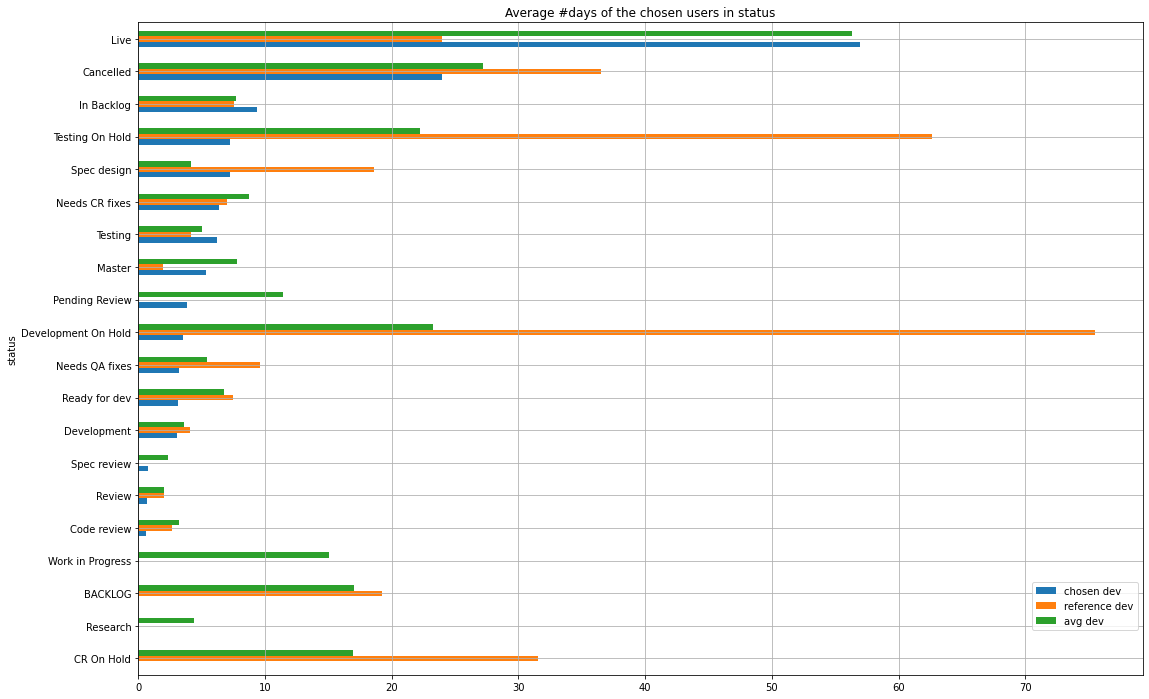

In [9]:
dev2 = developer.get_developer(sw, interval=active_interval, userId="matic.balantic")
avg_dev_by_status = avg_dev.sort_values("STATUS")
dev_by_status = dev.set_index("STATUS")
dev2_by_status = dev2.set_index("STATUS")
dev_by_status = dev_by_status.sort_values("STATUS")
dev2_by_status = dev2_by_status.sort_values("STATUS")

combined = pd.concat(
    [
        avg_dev_by_status["STATUS"].rename("status"),
        avg_dev_by_status["AVG_DAY"].rename("avg dev"),
        dev_by_status["AVG_DAY"].rename("chosen dev"),
        dev2_by_status["AVG_DAY"].rename("reference dev")
    ],
    axis=1,
    sort=False
).fillna(0)

plot = combined.loc[(combined["chosen dev"] > 0)]\
    .sort_values("chosen dev")\
    .plot(
        kind='barh',
        x="status",
        y=["chosen dev", "reference dev", "avg dev"],
        figsize=figure_size,
        grid=True,
        # yticks=range(0, int(dev["AVG_DAY"].max()) + 1, 1),
        title=f"Average #days of the chosen users in status"
    )\
    .legend(bbox_to_anchor=(1, 0.15))
fig = plot.get_figure()
fig.savefig(f"{data_root}/figs/avg_dev_{userId}_reference.png")

In [10]:
intervals = [
    Interval(fromDate=date(2019, 1, 1), toDate=date(2019, 4, 1)),
    Interval(fromDate=date(2019, 4, 1), toDate=date(2019, 7, 1)),
    Interval(fromDate=date(2019, 7, 1), toDate=date(2019, 10, 1)),
    Interval(fromDate=date(2019, 10, 1), toDate=date(2020, 1, 1))
]

In [11]:
avgs = [ developer.get_avg_developer(sw, interval) for interval in intervals ]

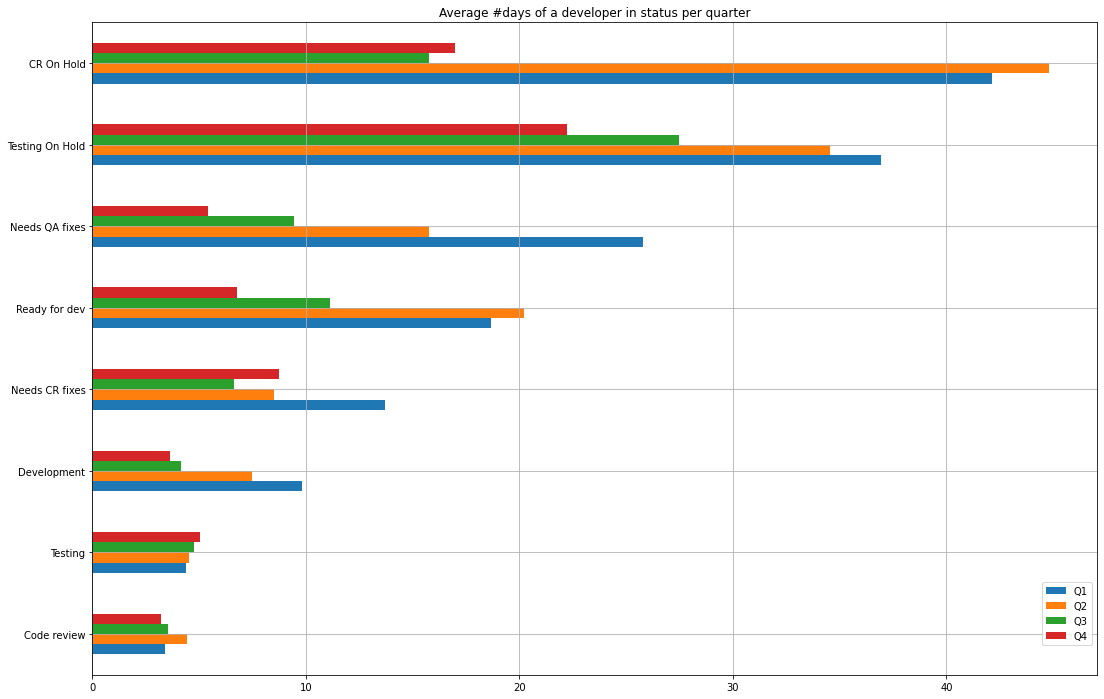

In [12]:
to_view_avg = pd.DataFrame()
for i, x in enumerate(avgs):
    to_view_avg = pd.concat(
        [
            to_view_avg,
            x["AVG_DAY"].rename(f"Q{i + 1}")
        ],
        axis=1,
        sort=False
    )

plot = to_view_avg\
    .loc[statuses_of_interest, :]\
    .sort_values("Q1")\
    .plot(
        kind='barh',
        use_index=True,
        y=["Q1", "Q2", "Q3", "Q4"],
        figsize=figure_size,
        grid=True,
        yticks=range(0, 50, 1),
        title="Average #days of a developer in status per quarter"
    )\
    .legend(bbox_to_anchor=(1, 0.15))
fig = plot.get_figure()
fig.savefig(f"{data_root}/figs/overall_avg_all_qs_{userId}.png")

In [13]:
dev_qs = [developer.get_developer(sw, interval=interval, userId=userId) for interval in intervals]

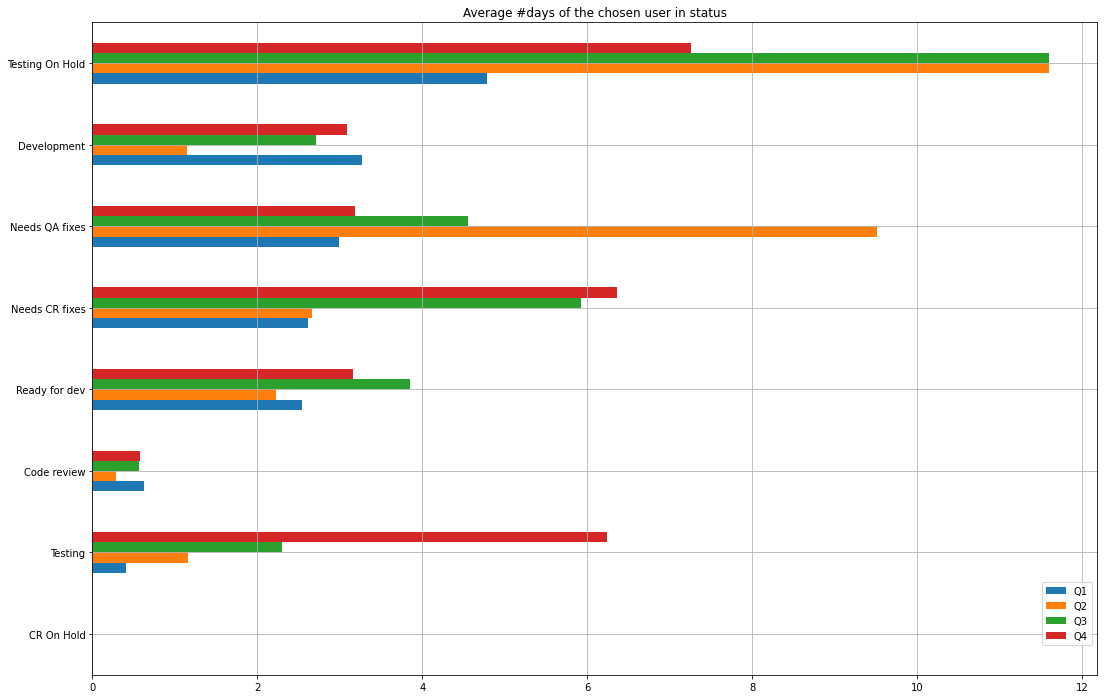

In [14]:
to_view = pd.DataFrame()
for i, x in enumerate(dev_qs):
    dev_q = x.set_index("STATUS")
    dev_q = dev_q.sort_values("STATUS")
    to_view = pd.concat(
        [
            to_view,
            dev_q["AVG_DAY"].rename(f"Q{i + 1}")
        ],
        axis=1,
        sort=False
    )

combined_dev_qs = pd.concat(
    [
        dev_qs[-1]["STATUS"].rename("status"),
        to_view
    ],
    axis=1,
    sort=False
).fillna(0)

plot = combined_dev_qs\
    .loc[statuses_of_interest, :]\
    .sort_values("Q1")\
    .plot(
        kind='barh',
        use_index=True, 
        y=["Q1", "Q2", "Q3", "Q4"], 
        figsize=figure_size, 
        grid=True,
        yticks=range(0, 30, 1),
        title=f"Average #days of the chosen user in status"
    )\
    .legend(bbox_to_anchor=(1, 0.15))
fig = plot.get_figure()
fig.savefig(f"{data_root}/figs/all_qs_{userId}.png")